In [15]:
import os
import gc
import ast
import random
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tqdm import tqdm
import torchaudio
import IPython.display as ipd
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score

import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import warnings
warnings.filterwarnings('ignore')

In [16]:
torch.cuda.is_available()

True

In [44]:
class config:
    seed=2022
    num_fold = 5
    sample_rate= 32_000
    sampleNum = 32_000*5
    n_fft=1024
    win_length = 1024
    hop_length=512
    n_mels=64
    duration=5
    num_classes = 152
    train_batch_size = 32
    valid_batch_size = 32
    epochs = 100
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    learning_rate = 1e-4
    
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything(config.seed)

# Train_Metadata Analysis

In [18]:
df = pd.read_csv('../input/temptest/resampleTrainMetadata.csv')
df.head()

,Unnamed: 0,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,time,url,filename,num_channels,num_frames,sample_rate,duration
0,0,afrsil1,[],['call'],17.1003,54.2844,Euodice cantans,African Silverbill,Boris Delahaie,Creative Commons Attribution-NonCommercial-Sha...,4.5,06:35,https://www.xeno-canto.org/395771,afrsil1/XC395771.ogg,1.0,871008.0,32000.0,27.219000
1,1,afrsil1,[],"['call', 'song']",16.2901,-16.0321,Euodice cantans,African Silverbill,Bram Piot,Creative Commons Attribution-NonCommercial-Sha...,4.0,11:30,https://www.xeno-canto.org/177993,afrsil1/XC177993.ogg,1.0,1720320.0,32000.0,53.760000
2,2,afrsil1,[],"['alarm call', 'call']",17.0922,54.2958,Euodice cantans,African Silverbill,Oscar Campbell,Creative Commons Attribution-NonCommercial-Sha...,4.0,11:00,https://www.xeno-canto.org/205893,afrsil1/XC205893.ogg,2.0,3375438.0,32000.0,105.482438
3,3,afrsil1,[],['flight call'],21.4581,-157.7252,Euodice cantans,African Silverbill,Ross Gallardy,Creative Commons Attribution-NonCommercial-Sha...,4.0,16:30,https://www.xeno-canto.org/207432,afrsil1/XC207432.ogg,2.0,112013.0,32000.0,3.500406
4,4,afrsil1,[],['call'],21.3561,-158.0205,Euodice cantans,African Silverbill,Ross Gallardy,Creative Commons Attribution-NonCommercial-Sha...,4.0,11:00,https://www.xeno-canto.org/209513,afrsil1/XC209513.ogg,2.0,1371742.0,32000.0,42.866937


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1405 entries, 0 to 1404
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        1405 non-null   int64  
 1   primary_label     1405 non-null   object 
 2   secondary_labels  1405 non-null   object 
 3   type              1405 non-null   object 
 4   latitude          1405 non-null   float64
 5   longitude         1405 non-null   float64
 6   scientific_name   1405 non-null   object 
 7   common_name       1405 non-null   object 
 8   author            1405 non-null   object 
 9   license           1405 non-null   object 
 10  rating            1405 non-null   float64
 11  time              1405 non-null   object 
 12  url               1405 non-null   object 
 13  filename          1405 non-null   object 
 14  num_channels      1405 non-null   float64
 15  num_frames        1405 non-null   float64
 16  sample_rate       1405 non-null   float64


In [20]:
df.describe()

,Unnamed: 0,latitude,longitude,rating,num_channels,num_frames,sample_rate,duration
count,1405.000000,1405.000000,1405.000000,1405.00000,1405.000000,1.405000e+03,1405.0,1405.000000
mean,702.000000,26.455300,-59.492201,4.62847,1.487544,1.423323e+06,32000.0,44.478843
std,405.732876,27.681837,88.601887,0.77834,0.500023,2.625578e+06,0.0,82.049318
min,0.000000,-71.883400,-176.632200,0.00000,1.000000,3.427300e+04,32000.0,1.071031
25%,351.000000,19.442400,-124.353700,4.50000,1.000000,3.427270e+05,32000.0,10.710219
50%,702.000000,28.681200,-80.694300,5.00000,1.000000,7.541760e+05,32000.0,23.568000
75%,1053.000000,46.950900,9.220600,5.00000,2.000000,1.606635e+06,32000.0,50.207344
max,1404.000000,78.978300,179.338100,5.00000,2.000000,6.439079e+07,32000.0,2012.212250


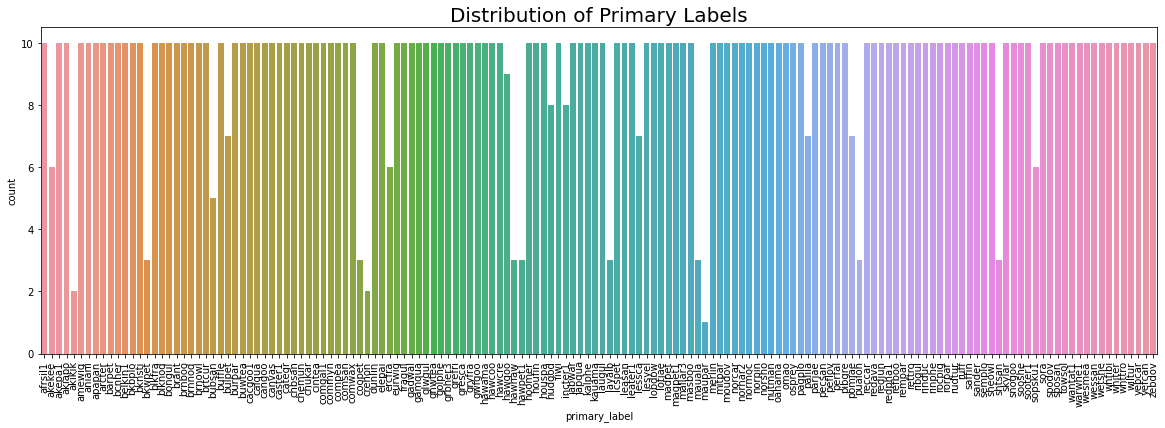

In [21]:
plt.figure(figsize=(20, 6))

sns.countplot(df['primary_label'])
plt.xticks(rotation=90)
plt.title("Distribution of Primary Labels", fontsize=20)

plt.show()

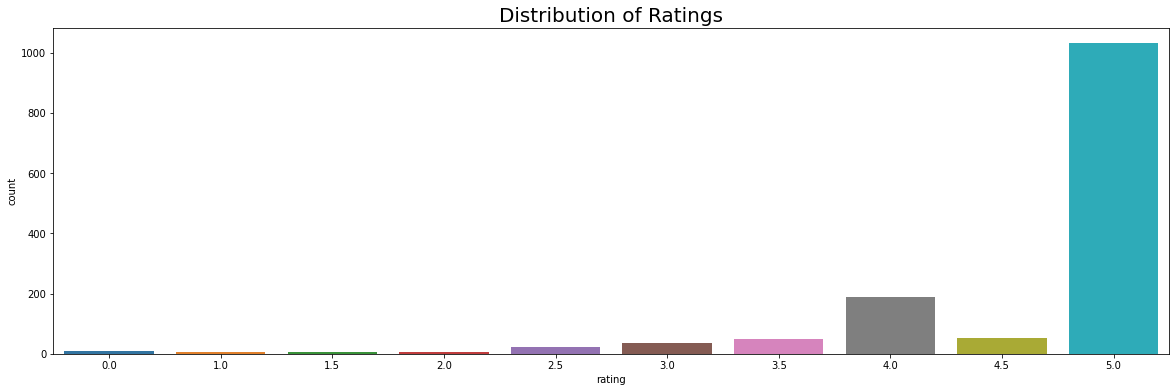

In [22]:
plt.figure(figsize=(20, 6))

sns.countplot(df['rating'])
plt.title("Distribution of Ratings", fontsize=20)

plt.show()

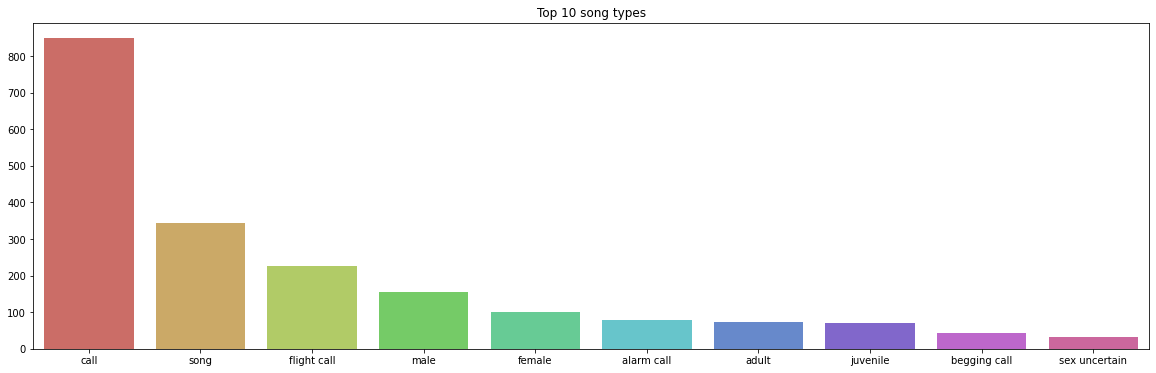

In [23]:
df['type'] = df['type'].apply(lambda x : ast.literal_eval(x))

top = Counter([typ.lower() for lst in df['type'] for typ in lst])

top = dict(top.most_common(10))

plt.figure(figsize=(20, 6))

sns.barplot(x=list(top.keys()), y=list(top.values()), palette='hls')
plt.title("Top 10 song types")

plt.show()

# Audio Analysis

In [24]:
filename_1 = df["filename"].values[0] # first training example
ipd.Audio(f"../input/birdclef-2022/train_audio/{filename_1}")

In [25]:
filename_2 = df["filename"].values[-1] # last training example
ipd.Audio(f"../input/birdclef-2022/train_audio/{filename_2}")

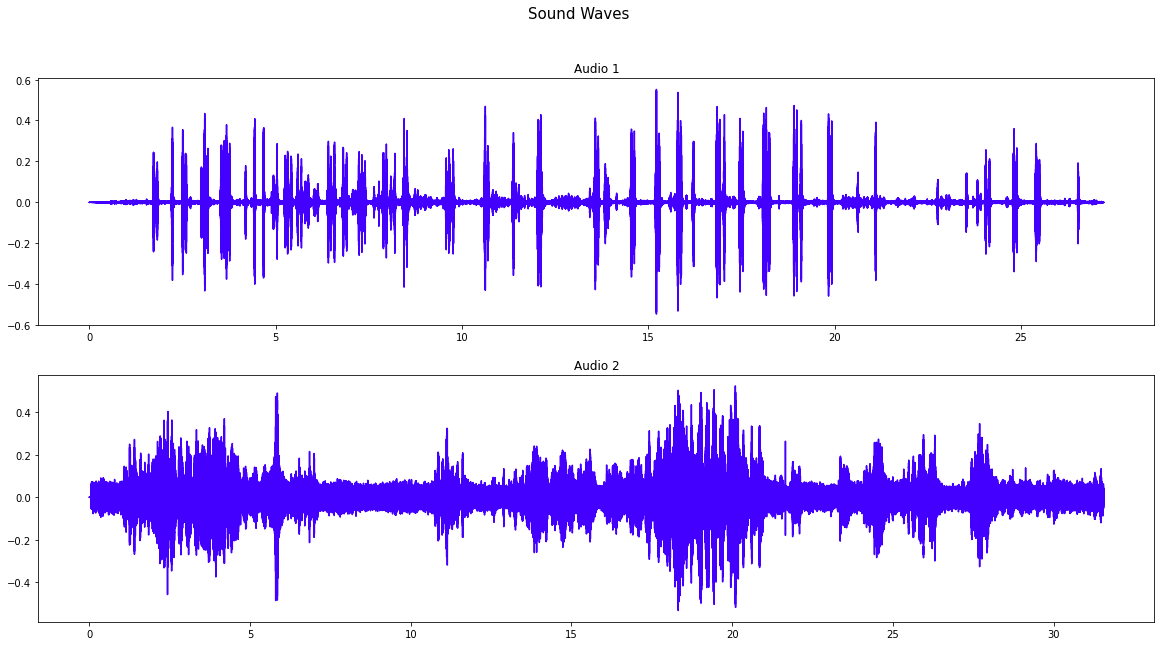

In [26]:
fig, ax = plt.subplots(2, 1, figsize=(20, 10))
fig.suptitle("Sound Waves", fontsize=15)

signal_1, sr = torchaudio.load(f"../input/birdclef-2022/train_audio/{filename_1}")
# The audio data consist of two things-
# Sound: sequence of vibrations in varying pressure strengths (y)
# Sample Rate: (sr) is the number of samples of audio carried per second, measured in Hz or kHz

sns.lineplot(x=np.arange(len(signal_1[0,:].detach().numpy()))/sr, y=signal_1[0,:].detach().numpy(), ax=ax[0], color='#4400FF')
ax[0].set_title("Audio 1")

signal_2, sr = torchaudio.load(f"../input/birdclef-2022/train_audio/{filename_2}")
sns.lineplot(x=np.arange(len(signal_2[0,:].detach().numpy()))/sr, y=signal_2[0,:].detach().numpy(), ax=ax[1], color='#4400FF')
ax[1].set_title("Audio 2")

plt.show()

# Preprocessing
## LabelEncoding

In [27]:
encoder = LabelEncoder()
df['primary_label_encoded'] = encoder.fit_transform(df['primary_label'])

## Create Folds


In [28]:
skf = StratifiedKFold(n_splits=config.num_fold)
for k, (_, val_ind) in enumerate(skf.split(X=df, y=df['primary_label_encoded'])):
    df.loc[val_ind, 'fold'] = k

## Waveform to Specgrum

torch.Size([1, 64, 1702])
torch.Size([2, 64, 1973])


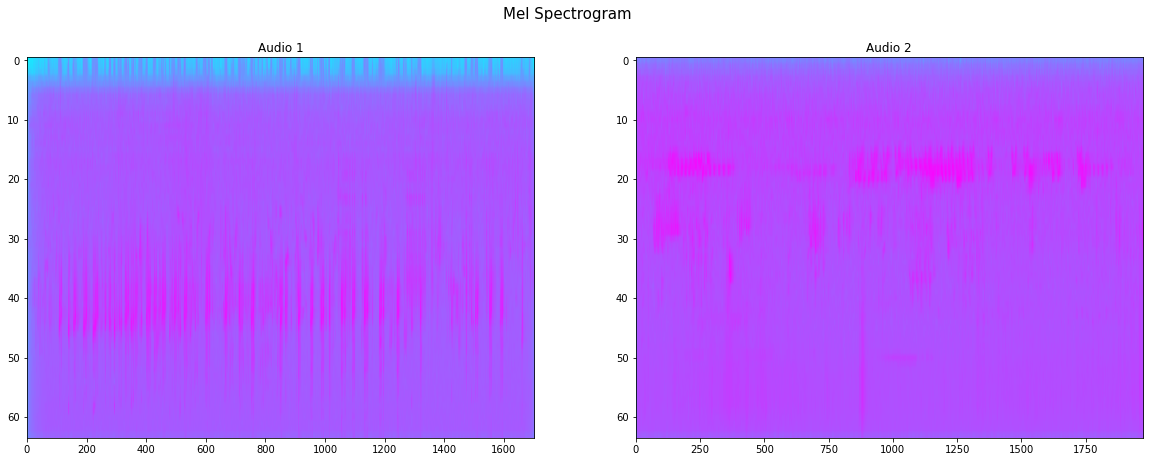

In [29]:
# show Mel Spectrogram for the audio
fig, ax = plt.subplots(1, 2, figsize=(20, 7))
fig.suptitle("Mel Spectrogram", fontsize=15)

mel_spectrogram = torchaudio.transforms.MelSpectrogram(sample_rate=config.sample_rate, 
                                                      n_fft=config.n_fft, 
                                                      hop_length=config.hop_length, 
                                                      n_mels=config.n_mels)

mel_1 = mel_spectrogram(signal_1)
ax[0].imshow(mel_1.log2()[0,:,:].detach().numpy(), aspect='auto', cmap='cool')
ax[0].set_title("Audio 1")
print(mel_1.shape)

mel_2 = mel_spectrogram(signal_2)
ax[1].imshow(mel_2.log2()[0,:,:].detach().numpy(), aspect='auto', cmap='cool')
ax[1].set_title("Audio 2")
print(mel_2.shape)

plt.show()

torch.Size([1, 513, 1702])
torch.Size([1, 513, 1973])


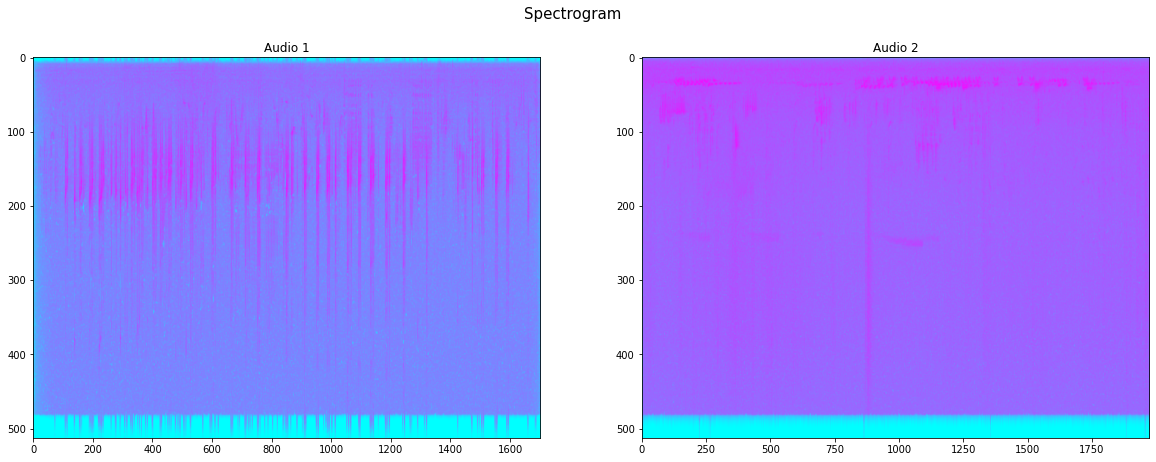

In [30]:
# show Spectrogram for the audio
fig, ax = plt.subplots(1, 2, figsize=(20, 7))
fig.suptitle("Spectrogram", fontsize=15)

spectrogram = torchaudio.transforms.Spectrogram(
    n_fft = config.n_fft,          # freqGroup = n_fft//2 + 1
    win_length = config.win_length, # freq gap for each group
    hop_length = config.hop_length, # length = samples / hop_length
    center = True,
    pad_mode = 'reflect',
    power=2.0
)

spec_1 = spectrogram(signal_1)
print(spec_1.shape)
ax[0].imshow(torchaudio.transforms.AmplitudeToDB()(spec_1[0]), aspect='auto', cmap='cool')
ax[0].set_title("Audio 1")

spec_2 = spectrogram(signal_2)
spec_2 = torch.mean(spec_2, axis=0, keepdim=True)
ax[1].imshow(torchaudio.transforms.AmplitudeToDB()(spec_2[0]), aspect='auto', cmap='cool')
ax[1].set_title("Audio 2")
print(spec_2.shape)
plt.show()

1. Not all the audio have same sample rate. Considerate resample so that they have same sample rate
1. Each audio signals can have different number of channels, so we will ensure that they are mono
1. Each sample have different time durations, so we need padding or truncating

## Load Partial Audio

In [31]:
filename = df.loc[0,'filename']
audio_path = f'../input/birdclef-2022/train_audio/{filename}'
signal, sr = torchaudio.load(audio_path,32000*10,config.sample_rate*config.duration)

In [32]:
maxSampleNum = signal.shape[1]
signal1, sr = torchaudio.load(audio_path,torch.randint(0,np.max([1,maxSampleNum-config.sampleNum+1]),[1]),config.sampleNum)
signal1.shape

torch.Size([1, 160000])

# Construction Dataset

In [33]:
class BirdClefDataset(Dataset):
    def __init__(self, df, transformation, target_sample_rate, duration):
        self.audio_paths = df['filename'].values
        self.labels = df['primary_label_encoded'].values
        self.transformation = transformation
        self.target_sample_rate = target_sample_rate
        self.num_samples = target_sample_rate*duration
        self.AmplitudeToDB = torchaudio.transforms.AmplitudeToDB()
        
    def __len__(self):
        return len(self.audio_paths)
    
    def __getitem__(self, index):
        audio_path = f'../input/birdclef-2022/train_audio/{self.audio_paths[index]}'
        signal, sr = torchaudio.load(audio_path) # loaded the audio
        
        # Resample ensure signal have same sample rate
        if sr != self.target_sample_rate:
            resampler = torchaudio.transforms.Resample(sr, self.target_sample_rate)
            signal = resampler(signal)
            
        # Ensure singal is mono
        if signal.shape[0]>1:
            signal = torch.mean(signal, axis=0, keepdim=True)
        
        # padding or truncating ignal
        if signal.shape[1] > self.num_samples:
            signal = signal[:, :self.num_samples]
        if signal.shape[1] < self.num_samples:
            num_missing_samples = self.num_samples - signal.shape[1]
            last_dim_padding = (0, num_missing_samples)
            signal = torch.nn.functional.pad(signal, last_dim_padding)
        
        
        spec = self.transformation(signal)        
        label = torch.tensor(self.labels[index])
        
        return spec, label

In [34]:
spectrogram = torchaudio.transforms.Spectrogram(
    n_fft = config.n_fft,          # freqGroup = n_fft//2 + 1
    win_length = config.win_length, # freq gap for each group
    hop_length = config.hop_length, # length = samples / hop_length
    center = True,
    pad_mode = 'reflect',
    power=2.0
)
# Get data according to the folds
def get_data(df,fold):
    train_df = df[df['fold'] != fold].reset_index(drop=True)
    valid_df = df[df['fold'] == fold].reset_index(drop=True)
    
    train_dataset = BirdClefDataset(train_df, spectrogram, config.sample_rate, config.duration)
    valid_dataset = BirdClefDataset(valid_df, spectrogram, config.sample_rate, config.duration)
    
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=config.train_batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=config.valid_batch_size, shuffle=True)
    
    return train_loader, valid_loader

# Model

In [40]:
class BirdClefModel(nn.Module):
    def __init__(self):
        super(BirdClefModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128*64*39, 64)
        self.fc2 = nn.Linear(64, config.num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        # 513*313
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        # 256*156
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        # 128*78
        x = self.pool(x)
        # 64*39
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

In [36]:
def loss_fn(outputs, labels):
    return nn.CrossEntropyLoss()(outputs, labels)

def train(model, data_loader, optimizer, scheduler, device, epoch):
    model.train()
    pred = []
    label = []
    
    running_loss = 0
    loop = tqdm(data_loader, position=0)
    for i, (spec, labels) in enumerate(loop):
        spec = spec.to(device)
        labels = labels.to(device)
        
        outputs = model(spec)
        _, preds = torch.max(outputs, 1)
        
        loss = loss_fn(outputs, labels)
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        if scheduler is not None:
            scheduler.step()
            
        running_loss += loss.item()
        pred.extend(preds.view(-1).cpu().detach().numpy())
        label.extend(labels.view(-1).cpu().detach().numpy())
        
        loop.set_description(f"Epoch [{epoch+1}/{config.epochs}]")
        loop.set_postfix(loss=loss.item())

    return running_loss/len(data_loader)

In [37]:
def valid(model, data_loader, device, epoch):
    model.eval()
    
    running_loss = 0
    pred = []
    label = []
    
    loop = tqdm(data_loader, position=0)
    for spec, labels in loop:
        spec = spec.to(device)
        labels = labels.to(device)
        
        outputs = model(spec)
        _, preds = torch.max(outputs, 1)
        
        loss = loss_fn(outputs, labels)
            
        running_loss += loss.item()
        
        pred.extend(preds.view(-1).cpu().detach().numpy())
        label.extend(labels.view(-1).cpu().detach().numpy())
        
        loop.set_description(f"Epoch [{epoch+1}/{config.epochs}]")
        loop.set_postfix(loss=loss.item())
        
    valid_f1 = f1_score(label, pred, average='macro')
    
    return running_loss/len(data_loader), valid_f1

In [38]:
def run(fold):
    train_loader, valid_loader = get_data(df,fold)
    model = BirdClefModel().to(config.device)
    
    optimizer = Adam(model.parameters(), lr=config.learning_rate)
    
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, eta_min=1e-5, T_max=10)
    
    best_valid_f1 = 0
    for epoch in range(config.epochs):
        train_loss = train(model, train_loader, optimizer, scheduler, config.device, epoch)
        valid_loss, valid_f1 = valid(model, valid_loader, config.device, epoch)
        if valid_f1 > best_valid_f1:
            print(f"Validation F1 Improved - {best_valid_f1} ---> {valid_f1}")
            torch.save(model.state_dict(), f'./model_{fold}.bin')
            print(f"Saved model checkpoint at ./model_{fold}.bin")
            best_valid_f1 = valid_f1
            
    return best_valid_f1

In [45]:
train_loader, valid_loader = get_data(df,1)

model = BirdClefModel().to(config.device)

optimizer = Adam(model.parameters(), lr=config.learning_rate)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, eta_min=1e-5, T_max=10)

best_valid_f1 = 0
for epoch in range(config.epochs):
    train_loss = train(model, train_loader, optimizer, scheduler, config.device, epoch)
    valid_loss, valid_f1 = valid(model, valid_loader, config.device, epoch)
    print('train Loss: ',train_loss,'valid Loss: ',valid_loss," vaild_F1",valid_f1)


Epoch [1/100]: 100%|██████████| 9/9 [00:18<00:00,  2.01s/it, loss=5.01]


train Loss:  10.312209831343758 valid Loss:  6.23380004035102  vaild_F1 0.009207737148913618


Epoch [2/100]: 100%|██████████| 9/9 [00:18<00:00,  2.00s/it, loss=5.19]


train Loss:  5.129764808548821 valid Loss:  5.777888033125135  vaild_F1 0.003515571408972424


Epoch [3/100]: 100%|██████████| 9/9 [00:18<00:00,  2.01s/it, loss=5.44]


train Loss:  4.677373442384932 valid Loss:  5.824180020226373  vaild_F1 0.008049716383049715


Epoch [4/100]: 100%|██████████| 9/9 [00:18<00:00,  2.03s/it, loss=5.78]


train Loss:  4.507186876402961 valid Loss:  5.922196335262722  vaild_F1 0.009645852749301026


Epoch [5/100]: 100%|██████████| 9/9 [00:18<00:00,  2.02s/it, loss=5.15]


train Loss:  4.377541727489895 valid Loss:  6.195068836212158  vaild_F1 0.006081081081081081


Epoch [6/100]: 100%|██████████| 9/9 [00:18<00:00,  2.05s/it, loss=8.02]


train Loss:  4.335046973493364 valid Loss:  6.61001459757487  vaild_F1 0.007558202738346577


Epoch [7/100]: 100%|██████████| 9/9 [00:18<00:00,  2.04s/it, loss=6.83]


train Loss:  4.196360786755879 valid Loss:  6.828438917795817  vaild_F1 0.010434862554013056


Epoch [8/100]: 100%|██████████| 9/9 [00:18<00:00,  2.08s/it, loss=4.92]


train Loss:  4.004061394267612 valid Loss:  7.628831916385227  vaild_F1 0.010084322836000689


Epoch [9/100]: 100%|██████████| 9/9 [00:18<00:00,  2.00s/it, loss=5.93]


train Loss:  3.8867733677228293 valid Loss:  7.770943429734972  vaild_F1 0.011987612249520909


Epoch [10/100]: 100%|██████████| 9/9 [00:17<00:00,  1.99s/it, loss=7.02]


train Loss:  3.7083846396870084 valid Loss:  8.45739550060696  vaild_F1 0.01632044316608075


Epoch [11/100]: 100%|██████████| 9/9 [00:17<00:00,  1.99s/it, loss=7.41]


train Loss:  3.493973500198788 valid Loss:  9.354844093322754  vaild_F1 0.015663506267533114


Epoch [12/100]: 100%|██████████| 9/9 [00:18<00:00,  2.02s/it, loss=7.98]


train Loss:  3.4447017510732016 valid Loss:  9.684793366326225  vaild_F1 0.015071225071225072


Epoch [13/100]: 100%|██████████| 9/9 [00:18<00:00,  2.02s/it, loss=10.9]


train Loss:  3.136941042211321 valid Loss:  11.261749956342909  vaild_F1 0.016394966394966393


Epoch [14/100]: 100%|██████████| 9/9 [00:18<00:00,  2.06s/it, loss=9.95]


train Loss:  3.153982828060786 valid Loss:  11.952050315009224  vaild_F1 0.013038548752834465


Epoch [15/100]: 100%|██████████| 9/9 [00:17<00:00,  1.98s/it, loss=8.54]


train Loss:  2.9203061064084372 valid Loss:  12.717940754360622  vaild_F1 0.019622882710131035


Epoch [16/100]: 100%|██████████| 9/9 [00:17<00:00,  1.98s/it, loss=6.39]


train Loss:  2.7064218521118164 valid Loss:  14.263148890601265  vaild_F1 0.018976008976008974


Epoch [17/100]: 100%|██████████| 9/9 [00:18<00:00,  2.01s/it, loss=29.8]


train Loss:  2.6979677610927157 valid Loss:  15.349449104732937  vaild_F1 0.010901718044575187


Epoch [18/100]: 100%|██████████| 9/9 [00:18<00:00,  2.01s/it, loss=12.8]


train Loss:  2.4691393772761026 valid Loss:  16.57769097222222  vaild_F1 0.020398970398970397


Epoch [19/100]: 100%|██████████| 9/9 [00:18<00:00,  2.01s/it, loss=10.2]


train Loss:  2.3625586132208505 valid Loss:  16.80014599694146  vaild_F1 0.018333333333333333


Epoch [20/100]: 100%|██████████| 9/9 [00:18<00:00,  2.02s/it, loss=15.7]


train Loss:  2.3175083928638034 valid Loss:  18.184835222032333  vaild_F1 0.014077040212057976


Epoch [21/100]: 100%|██████████| 9/9 [00:18<00:00,  2.01s/it, loss=8.79]


train Loss:  2.2363635765181646 valid Loss:  18.910788112216526  vaild_F1 0.022983913923511238


Epoch [22/100]: 100%|██████████| 9/9 [00:17<00:00,  2.00s/it, loss=8.78]


train Loss:  2.082821011543274 valid Loss:  20.13079908159044  vaild_F1 0.017355016348304938


Epoch [23/100]: 100%|██████████| 9/9 [00:17<00:00,  1.98s/it, loss=11.8]


train Loss:  1.9084320101473067 valid Loss:  20.676739798651802  vaild_F1 0.013252370299350164


Epoch [24/100]: 100%|██████████| 9/9 [00:18<00:00,  2.00s/it, loss=20.2]


train Loss:  1.814275046189626 valid Loss:  23.334450827704536  vaild_F1 0.017811048012390293


Epoch [25/100]: 100%|██████████| 9/9 [00:18<00:00,  2.06s/it, loss=19.6]


train Loss:  1.7857593215174146 valid Loss:  23.549573050604927  vaild_F1 0.01988778417349846


Epoch [26/100]: 100%|██████████| 9/9 [00:18<00:00,  2.06s/it, loss=42.2]


train Loss:  1.538475427362654 valid Loss:  25.85293854607476  vaild_F1 0.012666237666237666


Epoch [27/100]: 100%|██████████| 9/9 [00:18<00:00,  2.03s/it, loss=51.8]


train Loss:  1.4423663748635187 valid Loss:  29.564286973741318  vaild_F1 0.018822393822393823


Epoch [28/100]: 100%|██████████| 9/9 [00:18<00:00,  2.09s/it, loss=16.5]


train Loss:  1.2558722926510706 valid Loss:  32.080269283718536  vaild_F1 0.01925105675105675


Epoch [29/100]: 100%|██████████| 9/9 [00:18<00:00,  2.06s/it, loss=12.5]


train Loss:  1.1471247218756213 valid Loss:  31.502297507392036  vaild_F1 0.020338624338624336


Epoch [30/100]: 100%|██████████| 9/9 [00:18<00:00,  2.05s/it, loss=80.2]


train Loss:  1.231489348742697 valid Loss:  35.10768699645996  vaild_F1 0.020855270855270856


Epoch [31/100]: 100%|██████████| 9/9 [00:18<00:00,  2.04s/it, loss=17.7]


train Loss:  1.3234595275587506 valid Loss:  30.676836861504448  vaild_F1 0.031231231231231227


Epoch [32/100]: 100%|██████████| 9/9 [00:18<00:00,  2.07s/it, loss=23.7]


train Loss:  1.0994314725200336 valid Loss:  32.26523929172092  vaild_F1 0.033155261172502545


Epoch [33/100]: 100%|██████████| 9/9 [00:18<00:00,  2.05s/it, loss=23.5]


train Loss:  0.9986670745743645 valid Loss:  35.455177307128906  vaild_F1 0.021987036080995812


Epoch [34/100]: 100%|██████████| 9/9 [00:19<00:00,  2.14s/it, loss=32.9]


train Loss:  0.8523439131677151 valid Loss:  39.00737614101834  vaild_F1 0.026817889317889317


Epoch [35/100]: 100%|██████████| 9/9 [00:18<00:00,  2.04s/it, loss=27.8]


train Loss:  0.8418161695202192 valid Loss:  40.8451304965549  vaild_F1 0.0369020624122665


Epoch [36/100]: 100%|██████████| 9/9 [00:18<00:00,  2.06s/it, loss=89.6]


train Loss:  1.0704071289963193 valid Loss:  42.35733773973253  vaild_F1 0.03502788502788503


Epoch [37/100]: 100%|██████████| 9/9 [00:18<00:00,  2.08s/it, loss=19.4]


train Loss:  0.9183005173173215 valid Loss:  38.59243795606825  vaild_F1 0.028362290862290862


Epoch [38/100]: 100%|██████████| 9/9 [00:18<00:00,  2.07s/it, loss=22.9]


train Loss:  0.7290310429978288 valid Loss:  42.951296700371635  vaild_F1 0.03224666489972612


Epoch [39/100]: 100%|██████████| 9/9 [00:18<00:00,  2.09s/it, loss=53.9]


train Loss:  0.7259744685143232 valid Loss:  44.53286467658149  vaild_F1 0.03916423712342079


Epoch [40/100]: 100%|██████████| 9/9 [00:18<00:00,  2.06s/it, loss=74.7]


train Loss:  0.643118386881219 valid Loss:  48.445124520195854  vaild_F1 0.028388567297174216


Epoch [41/100]: 100%|██████████| 9/9 [00:18<00:00,  2.04s/it, loss=97]  


train Loss:  0.5980217287109958 valid Loss:  51.976081424289276  vaild_F1 0.03226433430515064


Epoch [42/100]: 100%|██████████| 9/9 [00:18<00:00,  2.03s/it, loss=52.8]


train Loss:  0.6464973410798444 valid Loss:  52.25549719068739  vaild_F1 0.034120754528917795


Epoch [43/100]: 100%|██████████| 9/9 [00:18<00:00,  2.06s/it, loss=61.8]


train Loss:  0.6617563149581352 valid Loss:  50.44236691792806  vaild_F1 0.046762021762021766


Epoch [44/100]: 100%|██████████| 9/9 [00:18<00:00,  2.08s/it, loss=36.5]


train Loss:  0.8727178706063164 valid Loss:  46.5916748046875  vaild_F1 0.0336602884397002


Epoch [45/100]: 100%|██████████| 9/9 [00:19<00:00,  2.14s/it, loss=21.5]


train Loss:  1.1791932880878448 valid Loss:  40.63918134901259  vaild_F1 0.04237775647171621


Epoch [46/100]: 100%|██████████| 9/9 [00:18<00:00,  2.04s/it, loss=32.7]


train Loss:  0.7170527263854941 valid Loss:  42.62356948852539  vaild_F1 0.0413022351797862


Epoch [47/100]: 100%|██████████| 9/9 [00:18<00:00,  2.05s/it, loss=41.2]


train Loss:  0.5258918332142962 valid Loss:  46.799931632147896  vaild_F1 0.0333495302883058


Epoch [48/100]: 100%|██████████| 9/9 [00:19<00:00,  2.11s/it, loss=105] 


train Loss:  0.4862583527962367 valid Loss:  51.90227275424533  vaild_F1 0.04034038523834443


Epoch [49/100]: 100%|██████████| 9/9 [00:18<00:00,  2.08s/it, loss=29.3]


train Loss:  0.49241513489849037 valid Loss:  54.044066958957245  vaild_F1 0.0404976404976405


Epoch [50/100]: 100%|██████████| 9/9 [00:17<00:00,  1.97s/it, loss=37.6]


train Loss:  0.6120893375741111 valid Loss:  54.559654235839844  vaild_F1 0.04250858000858001


Epoch [51/100]: 100%|██████████| 9/9 [00:18<00:00,  2.00s/it, loss=28.2]


train Loss:  0.5908103928797774 valid Loss:  50.9948550330268  vaild_F1 0.04412050534499514


Epoch [52/100]: 100%|██████████| 9/9 [00:18<00:00,  2.01s/it, loss=99.2]


train Loss:  0.5725999479699466 valid Loss:  56.345843421088325  vaild_F1 0.05246733614080552


Epoch [53/100]: 100%|██████████| 9/9 [00:18<00:00,  2.01s/it, loss=38.8]


train Loss:  0.48334562095503014 valid Loss:  58.04308742947049  vaild_F1 0.05183025591188856


Epoch [54/100]: 100%|██████████| 9/9 [00:18<00:00,  2.06s/it, loss=34]  


train Loss:  0.5095051776410805 valid Loss:  59.32052040100098  vaild_F1 0.04436885865457294


Epoch [55/100]: 100%|██████████| 9/9 [00:18<00:00,  2.07s/it, loss=48.6]


train Loss:  0.46641825056738323 valid Loss:  60.552461094326446  vaild_F1 0.04132972092155766


Epoch [56/100]: 100%|██████████| 9/9 [00:18<00:00,  2.06s/it, loss=89.8]


train Loss:  0.41566514492862755 valid Loss:  63.969946967230904  vaild_F1 0.04866154253909356


Epoch [57/100]: 100%|██████████| 9/9 [00:18<00:00,  2.05s/it, loss=31.7]


train Loss:  0.4614708110327936 valid Loss:  64.5072455936008  vaild_F1 0.05177086707698953


Epoch [58/100]: 100%|██████████| 9/9 [00:18<00:00,  2.08s/it, loss=61.1]


train Loss:  0.4376020172300438 valid Loss:  64.6448745727539  vaild_F1 0.05564671814671815


Epoch [59/100]: 100%|██████████| 9/9 [00:18<00:00,  2.04s/it, loss=28.7]


train Loss:  0.46452383742790615 valid Loss:  62.8318903181288  vaild_F1 0.06380845130845131


Epoch [60/100]: 100%|██████████| 9/9 [00:18<00:00,  2.08s/it, loss=28.7]


train Loss:  0.4086707668999831 valid Loss:  63.85359255472819  vaild_F1 0.05706778206778207


Epoch [61/100]: 100%|██████████| 9/9 [00:18<00:00,  2.07s/it, loss=85.9]


train Loss:  0.5507236235361133 valid Loss:  66.88127199808757  vaild_F1 0.0587998712998713


Epoch [62/100]: 100%|██████████| 9/9 [00:18<00:00,  2.08s/it, loss=37.4]


train Loss:  0.6868082943061987 valid Loss:  56.05256779988607  vaild_F1 0.05788288288288288


Epoch [63/100]: 100%|██████████| 9/9 [00:18<00:00,  2.04s/it, loss=40.4]


train Loss:  0.4384665564737386 valid Loss:  58.08106507195367  vaild_F1 0.05699806949806951


Epoch [64/100]: 100%|██████████| 9/9 [00:19<00:00,  2.11s/it, loss=44.3]


train Loss:  0.3388245655223727 valid Loss:  61.46816380818685  vaild_F1 0.0613454777884308


Epoch [65/100]: 100%|██████████| 9/9 [00:17<00:00,  1.98s/it, loss=70]  


train Loss:  0.32495022010213387 valid Loss:  65.21364720662434  vaild_F1 0.06007494720483272


Epoch [66/100]: 100%|██████████| 9/9 [00:17<00:00,  1.99s/it, loss=49.5]


train Loss:  0.39335794125994045 valid Loss:  65.79044342041016  vaild_F1 0.06492207621303556


Epoch [67/100]: 100%|██████████| 9/9 [00:18<00:00,  2.01s/it, loss=51.6]


train Loss:  0.2903291101360487 valid Loss:  69.3916727701823  vaild_F1 0.06086609140300416


Epoch [68/100]: 100%|██████████| 9/9 [00:18<00:00,  2.03s/it, loss=50.9]


train Loss:  0.2772511801061531 valid Loss:  72.39854431152344  vaild_F1 0.06408470841533363


Epoch [69/100]: 100%|██████████| 9/9 [00:18<00:00,  2.11s/it, loss=57.9]


train Loss:  0.27716357936151326 valid Loss:  75.46939892239041  vaild_F1 0.061217641418983705


Epoch [70/100]: 100%|██████████| 9/9 [00:18<00:00,  2.03s/it, loss=48]  


train Loss:  0.26804045500789975 valid Loss:  77.21633360120985  vaild_F1 0.06515160118101294


Epoch [71/100]: 100%|██████████| 9/9 [00:18<00:00,  2.04s/it, loss=73.3]


train Loss:  0.33644086288081276 valid Loss:  79.77101601494684  vaild_F1 0.06581402831402831


Epoch [72/100]: 100%|██████████| 9/9 [00:18<00:00,  2.10s/it, loss=74.8]


train Loss:  0.2600333452121251 valid Loss:  81.54038874308269  vaild_F1 0.06108980504953659


Epoch [73/100]: 100%|██████████| 9/9 [00:18<00:00,  2.05s/it, loss=53.4]


train Loss:  0.25533085766558844 valid Loss:  83.78499984741211  vaild_F1 0.05795400663821716


Epoch [74/100]: 100%|██████████| 9/9 [00:18<00:00,  2.08s/it, loss=122] 


train Loss:  0.26432150179365027 valid Loss:  86.95088365342882  vaild_F1 0.05412376662376662


Epoch [75/100]: 100%|██████████| 9/9 [00:17<00:00,  1.95s/it, loss=53]  


train Loss:  0.8238948423596513 valid Loss:  70.69328265719943  vaild_F1 0.05388080388080388


Epoch [76/100]: 100%|██████████| 9/9 [00:17<00:00,  1.97s/it, loss=49]  


train Loss:  0.7966011836090021 valid Loss:  58.511732737223305  vaild_F1 0.044439117929050816


Epoch [77/100]: 100%|██████████| 9/9 [00:18<00:00,  2.04s/it, loss=44.3]


train Loss:  0.4780240287590358 valid Loss:  51.45164934794108  vaild_F1 0.047303451581975076


Epoch [78/100]: 100%|██████████| 9/9 [00:17<00:00,  1.96s/it, loss=103] 


train Loss:  0.3793862947366302 valid Loss:  57.93732812669542  vaild_F1 0.054735579735579735


Epoch [79/100]: 100%|██████████| 9/9 [00:18<00:00,  2.04s/it, loss=53.4]


train Loss:  0.32267175511353546 valid Loss:  60.76603783501519  vaild_F1 0.05221471471471471


Epoch [80/100]: 100%|██████████| 9/9 [00:18<00:00,  2.01s/it, loss=28.7]


train Loss:  0.3275801905482594 valid Loss:  63.83087370130751  vaild_F1 0.04157877916267178


Epoch [81/100]: 100%|██████████| 9/9 [00:18<00:00,  2.01s/it, loss=114] 


train Loss:  0.34407568133125704 valid Loss:  64.25494066874187  vaild_F1 0.04961649089165868


Epoch [82/100]: 100%|██████████| 9/9 [00:17<00:00,  1.99s/it, loss=113] 


train Loss:  0.2997008097457486 valid Loss:  64.78163104587131  vaild_F1 0.05566280566280566


Epoch [83/100]: 100%|██████████| 9/9 [00:18<00:00,  2.01s/it, loss=80.4]


train Loss:  0.2751366685455044 valid Loss:  64.58384280734592  vaild_F1 0.05405405405405406


Epoch [84/100]: 100%|██████████| 9/9 [00:17<00:00,  1.98s/it, loss=75.5]


train Loss:  0.2948349015269842 valid Loss:  67.94736692640517  vaild_F1 0.051779279279279285


Epoch [85/100]: 100%|██████████| 9/9 [00:18<00:00,  2.02s/it, loss=26.5]


train Loss:  0.32238680470941794 valid Loss:  69.70233239067926  vaild_F1 0.05385639714498775


Epoch [86/100]: 100%|██████████| 9/9 [00:17<00:00,  1.99s/it, loss=100] 


train Loss:  0.33796112790393334 valid Loss:  67.81773800320096  vaild_F1 0.05633322680302545


Epoch [87/100]: 100%|██████████| 9/9 [00:18<00:00,  2.07s/it, loss=44.5]


train Loss:  0.30238976074744844 valid Loss:  66.97903060913086  vaild_F1 0.05665281772664323


Epoch [88/100]: 100%|██████████| 9/9 [00:18<00:00,  2.04s/it, loss=51.7]


train Loss:  0.30897009456788915 valid Loss:  67.70304743448894  vaild_F1 0.05775540641312452


Epoch [89/100]: 100%|██████████| 9/9 [00:18<00:00,  2.08s/it, loss=68.9]


train Loss:  0.2303704455520751 valid Loss:  70.24361970689561  vaild_F1 0.05732395866624054


Epoch [90/100]: 100%|██████████| 9/9 [00:18<00:00,  2.06s/it, loss=68.2]


train Loss:  0.28123543152792585 valid Loss:  72.47551727294922  vaild_F1 0.056524981357196115


Epoch [91/100]: 100%|██████████| 9/9 [00:18<00:00,  2.05s/it, loss=67.8]


train Loss:  0.23583118673963732 valid Loss:  73.61065673828125  vaild_F1 0.05633462851760272


Epoch [92/100]: 100%|██████████| 9/9 [00:18<00:00,  2.06s/it, loss=78.8]


train Loss:  0.23084983855692875 valid Loss:  77.16512891981337  vaild_F1 0.04986519818734583


Epoch [93/100]: 100%|██████████| 9/9 [00:18<00:00,  2.09s/it, loss=138] 


train Loss:  0.25993224076228216 valid Loss:  83.01869328816731  vaild_F1 0.05178970917225951


Epoch [94/100]: 100%|██████████| 9/9 [00:18<00:00,  2.03s/it, loss=60.1]


train Loss:  0.3548912337670724 valid Loss:  84.34219487508138  vaild_F1 0.052710376871450686


Epoch [95/100]: 100%|██████████| 9/9 [00:18<00:00,  2.08s/it, loss=127] 


train Loss:  0.30298829699556035 valid Loss:  82.80878618028429  vaild_F1 0.04903057419835943


Epoch [96/100]: 100%|██████████| 9/9 [00:18<00:00,  2.02s/it, loss=129] 


train Loss:  0.4399820463990586 valid Loss:  75.68639797634549  vaild_F1 0.052716522850751034


Epoch [97/100]: 100%|██████████| 9/9 [00:18<00:00,  2.05s/it, loss=53.8]


train Loss:  0.48132415053670585 valid Loss:  65.05507575141058  vaild_F1 0.0533033033033033


Epoch [98/100]: 100%|██████████| 9/9 [00:18<00:00,  2.05s/it, loss=60.2]


train Loss:  0.4890151346981939 valid Loss:  63.12058427598741  vaild_F1 0.04188750438750438


Epoch [99/100]: 100%|██████████| 9/9 [00:18<00:00,  2.02s/it, loss=44.3]


train Loss:  1.1888781320303679 valid Loss:  45.54260381062826  vaild_F1 0.04271235521235521


Epoch [100/100]: 100%|██████████| 9/9 [00:18<00:00,  2.03s/it, loss=32.9]

train Loss:  0.5348513788647122 valid Loss:  44.83611657884386  vaild_F1 0.05124946374946375


In [46]:
torch.save(model.state_dict(), f'./model.bin')

In [41]:
for fold in range(config.num_fold):
    print("=" * 30)ls
    print("Training Fold - ", fold)
    print("=" * 30)
    best_valid_f1 = run(fold)
    print(f'Best F1 Score: {best_valid_f1:.5f}')
    
    gc.collect()
    torch.cuda.empty_cache()   

Training Fold -  0


Epoch [3/5]: 100%|██████████| 18/18 [00:14<00:00,  1.21it/s, loss=4.92]


Validation F1 Improved - 0 ---> 0.005344995140913509
Saved model checkpoint at ./model_0.bin


Epoch [4/5]: 100%|██████████| 18/18 [00:15<00:00,  1.17it/s, loss=6.47]


Validation F1 Improved - 0.005344995140913509 ---> 0.010563114134542707
Saved model checkpoint at ./model_0.bin


Epoch [5/5]: 100%|██████████| 18/18 [00:15<00:00,  1.18it/s, loss=4.8] 


Best F1 Score: 0.01056
Training Fold -  1


Epoch [1/5]: 100%|██████████| 18/18 [00:18<00:00,  1.00s/it, loss=5.07]


Validation F1 Improved - 0 ---> 0.003480568128609334
Saved model checkpoint at ./model_1.bin


  0%|          | 0/18 [00:01<?, ?it/s]


KeyboardInterrupt: 